<a href="https://colab.research.google.com/github/csdahunzi/summer-course/blob/main/hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



##In this portion of the Problem Set, you will implement a network for semantic segmentation in image data, and also generate estimates of aleatoric and epistemic uncertainties associated with the segmentation. You are flexible in the model and architecture you choose. Your solution should follow this general template and provide the relevant deliverables:

In [12]:
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F
import random
import torch
import numpy as np
import h5py
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
path = "/content/drive/MyDrive/hw/"
os.chdir(path)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
MODE = 'TRAIN' # set MODE='TEST' to test without training
#hyperparameter
class_num = 34
num_epochs = 10 
batch_size = 24 
learning_rate = 1e-5
log_interval = 10
seed = 30
val_percent = 0.2 
torch.manual_seed(seed)
batchNorm_momentum = 0.1  # momentum for batch normalization

dir_pre_train_weights = "vgg16_pretrain_model.pth" 
dir_weights = "./weights"
dir_checkpoint = './checkpoints'

##1.Download the data. It is provided in lab2_train_data.h5 and lab2_test_data.h5 . The data are stored in h5 py format and contain the following fields:
### a. rgb: (NxHxWx3) collection of color images 
### b. seg: (NxHxWx1) collection of segmentation maps with classes labelled by index (the index ranges from 0 to K-1) 
### c. color_codes: (Kx3) list of RGB colors for labelling every segmentation class
##Implement a data loader class to handle the downloaded data. For more information on the dataset please refer to: CityScapes dataset . (5 points)

In [5]:
class getData(Dataset):
  def __init__(self, filepath):
    f = h5py.File(filepath, 'r')
    self.rgb = f['rgb']
    self.seg = f['seg']
  def __getitem__(self, idx):
    label = torch.tensor(self.seg[idx]).float()
    data = torch.tensor(self.rgb[idx]).float()
    data = data / 255.0  
    data = data.permute(2, 0, 1) 
    return data, label

  def __len__(self):
    return self.rgb.shape[0]
color_codes = h5py.File("lab2_test_data.h5", 'r')['color_codes']

In [6]:
# 1. Create dataset
dataset = getData("lab2_train_data.h5")
testset = getData("lab2_test_data.h5")

# 2. Split into train / validation partitions
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val])

# 3. Create data loaders
loader_args = dict(batch_size=batch_size,  pin_memory=True,drop_last = True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, **loader_args)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

##2.Define the model. Provide a schematic of your architecture depicting its overall structure and the relevant parameters. (20 points)

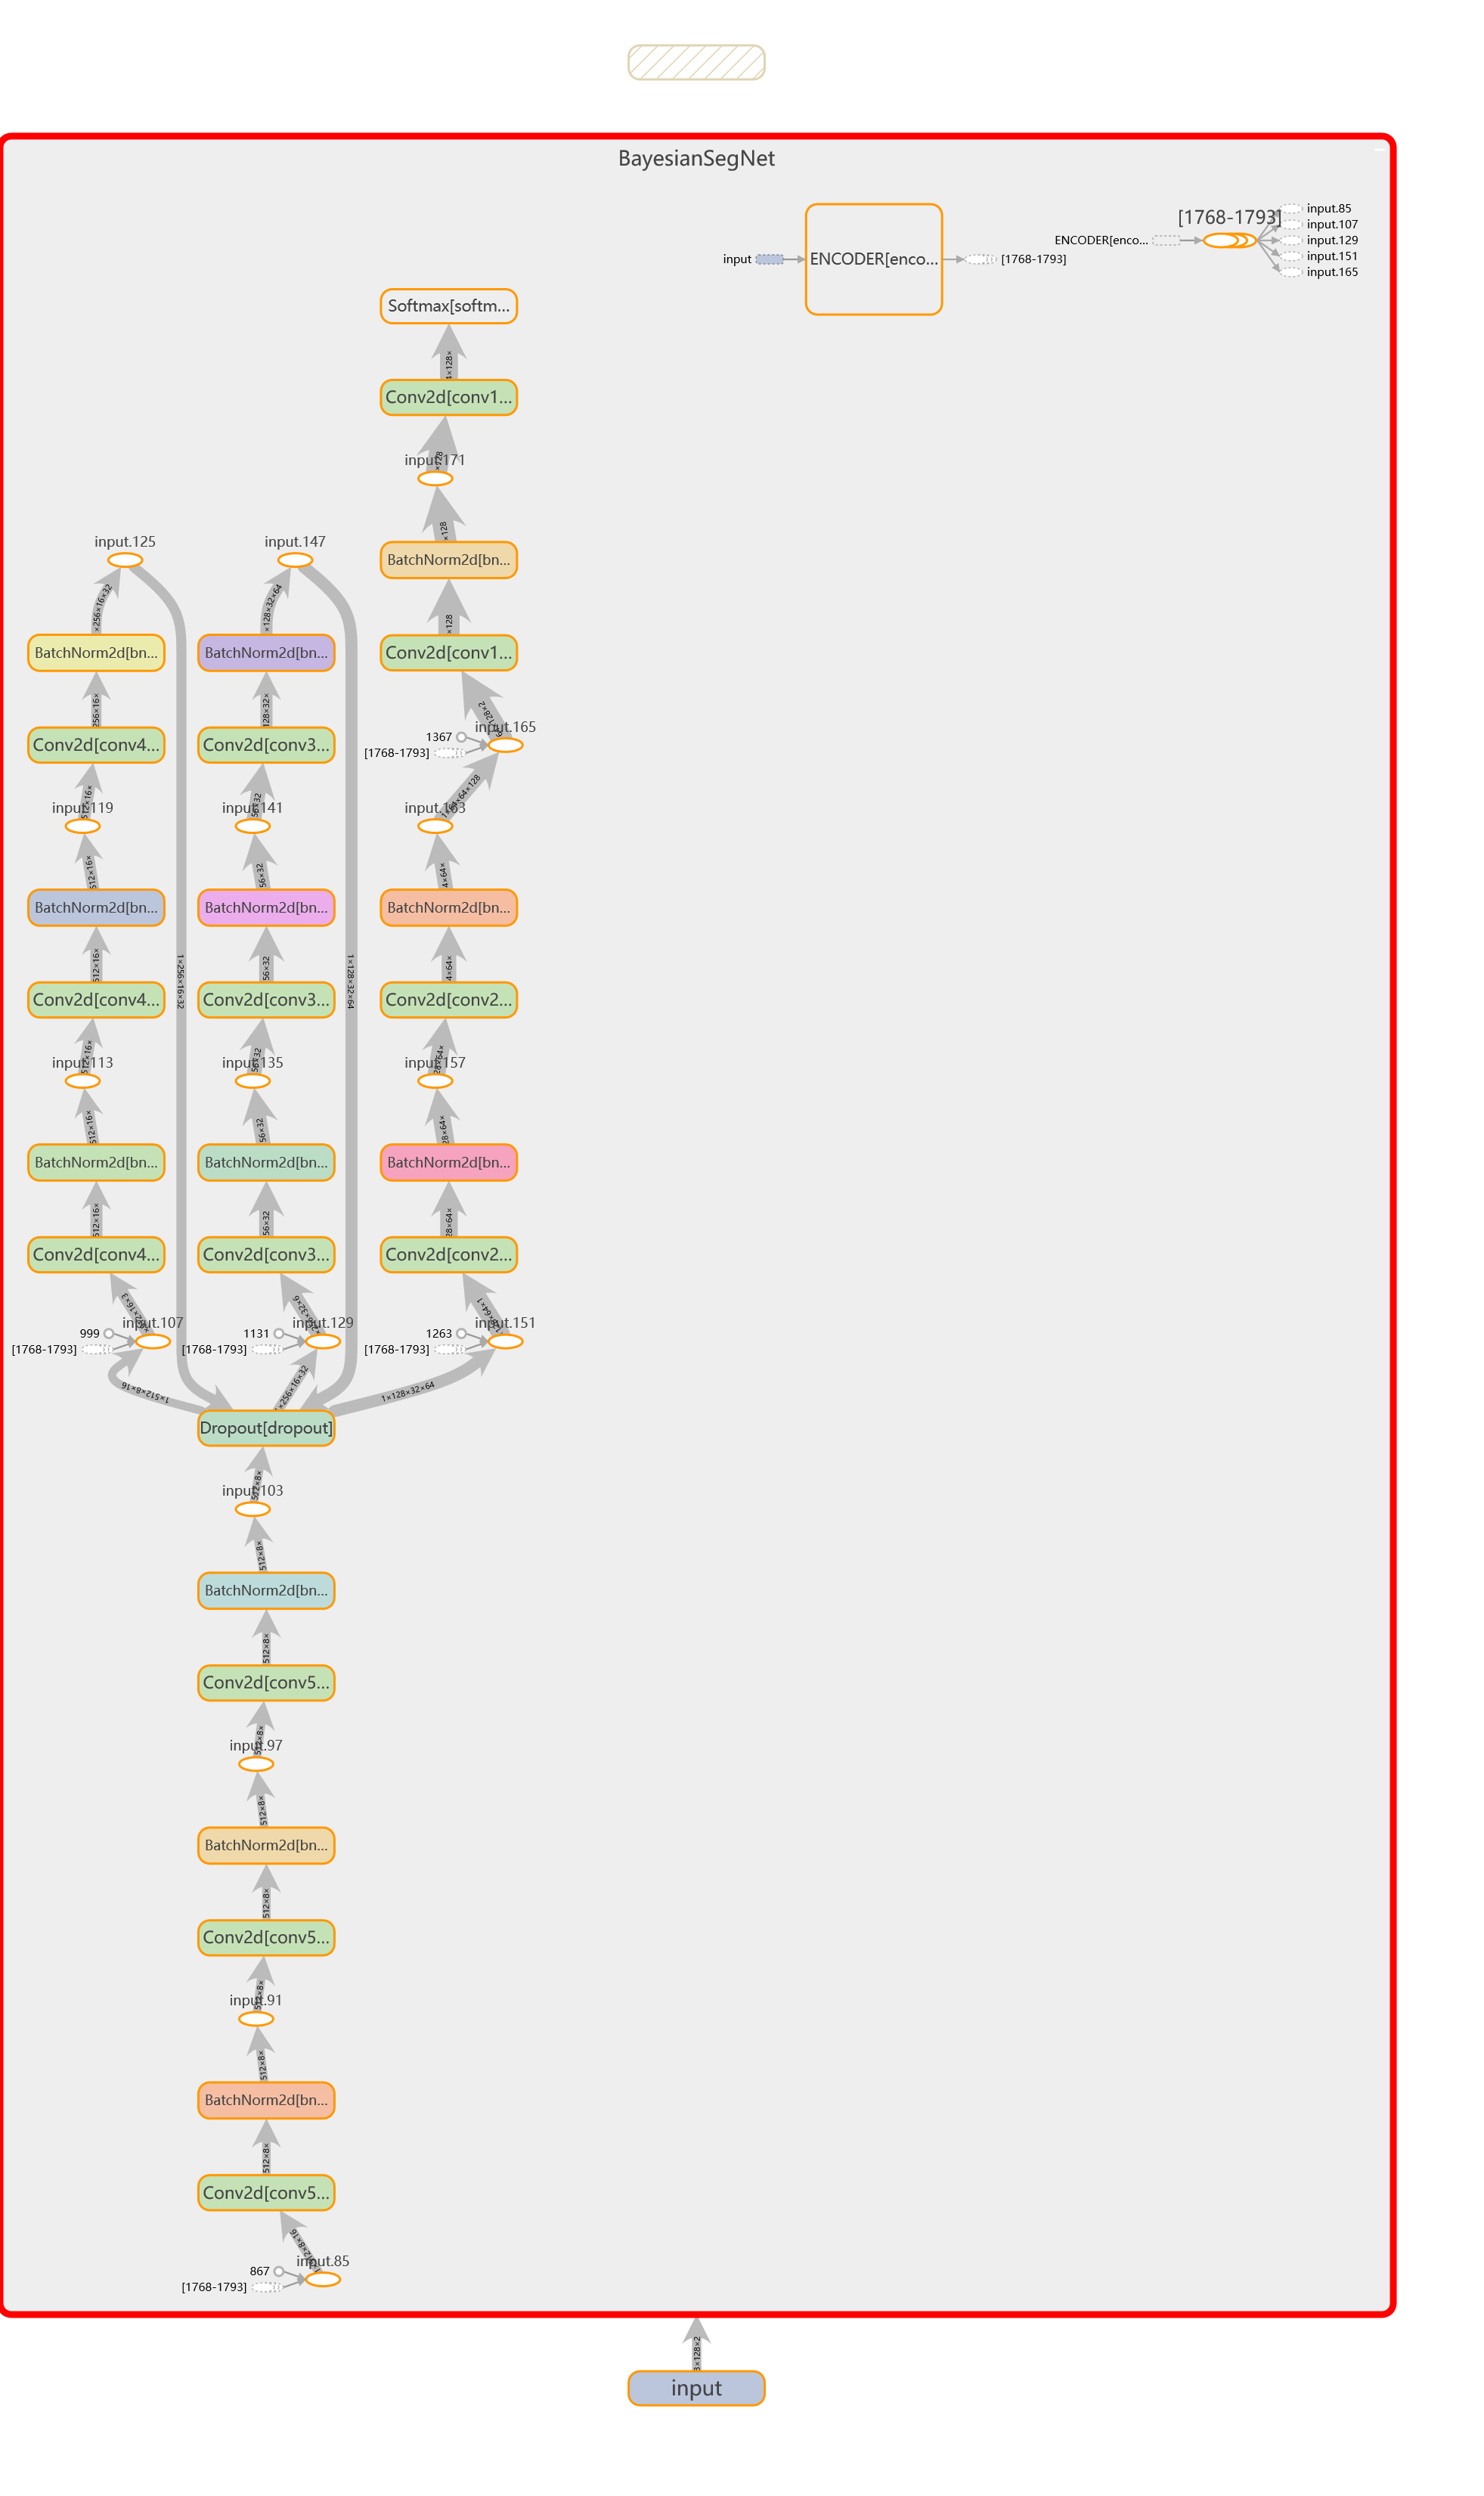

In [7]:
class ENCODER(nn.Module):
    def __init__(self, in_channels):
        super(ENCODER, self).__init__()

        self.conv11 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.dropout = nn.Dropout()
    def forward(self, x):
        id = []
        x_size = []
        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1_size = x12.size()
        x1p, id1 = F.max_pool2d(x12,kernel_size=2, stride=2,return_indices=True)
        id.append(id1)
        x_size.append(x1_size)
        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2_size = x22.size()
        x2p, id2 = F.max_pool2d(x22,kernel_size=2, stride=2,return_indices=True)
        id.append(id2)
        x_size.append(x2_size)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3_size = x33.size()
        x3p, id3 = F.max_pool2d(x33,kernel_size=2, stride=2,return_indices=True)
        x3p = self.dropout(x3p)
        id.append(id3)
        x_size.append(x3_size)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4_size = x43.size()
        x4p, id4 = F.max_pool2d(x43,kernel_size=2, stride=2,return_indices=True)
        x4p = self.dropout(x4p)
        id.append(id4)
        x_size.append(x4_size)

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5_size = x53.size()
        x5p, id5 = F.max_pool2d(x53,kernel_size=2, stride=2,return_indices=True)
        x5p = self.dropout(x5p)
        id.append(id5)
        x_size.append(x5_size)

        return x5p, id, x_size

class BayesianSegNet(nn.Module):
    def __init__(self,in_channels,output_channels):
        super(BayesianSegNet, self).__init__()
        self.Weight = self.state_dict()

        self.encoder = ENCODER(in_channels)
        self.dropout = nn.Dropout()
        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, output_channels, kernel_size=3, padding=1)
        self.softmax = nn.Softmax()

    def forward(self, x):

        x,id,x_size = self.encoder(x)
        
        # Stage 5d
        x5d = F.max_unpool2d(x, id[4], kernel_size=2, stride=2, output_size=x_size[4])
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))
        x51d = self.dropout(x51d)

        # Stage 4d
        x4d = F.max_unpool2d(x51d, id[3], kernel_size=2, stride=2, output_size=x_size[3])
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))
        x41d = self.dropout(x41d)

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id[2], kernel_size=2, stride=2, output_size=x_size[2])
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))
        x31d = self.dropout(x31d)

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id[1], kernel_size=2, stride=2, output_size=x_size[1])
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id[0], kernel_size=2, stride=2, output_size=x_size[0])
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)
        x11d = self.softmax(x11d)

        return x11d
    def load_from_VGGNET(self, net_path):
        old_weights = torch.load(net_path)
        del old_weights["classifier.0.weight"]
        del old_weights["classifier.0.bias"]
        del old_weights["classifier.3.weight"]
        del old_weights["classifier.3.bias"]
        del old_weights["classifier.6.weight"]
        del old_weights["classifier.6.bias"]

        names = []
        for key, value in self.encoder.state_dict().items():
          if "num_batches_tracked" in key:
              continue
          names.append(key)

        for name, dict in zip(names, old_weights.items()):
            self.Weight[name] = dict[1]
        self.encoder.load_state_dict(self.Weight)

In [13]:
net = BayesianSegNet(in_channels=3,output_channels=class_num)
net = net.to(device)
writer = SummaryWriter("logs_seq")
x = torch.ones((1,3,128,256))
writer.add_graph(net,x)
writer.close()

## 3.Define the loss function and optimizer. (10 points)

In [ ]:
optim = optim.Adam(params=net.parameters(),lr=learning_rate)
loss = nn.CrossEntropyLoss().to(device)

## 4.Train the network. (5 points)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]

In [ ]:
def train(epoch):
  net.train()
  pbar = tqdm(train_loader)
  for batch_idx, (train_data, target) in enumerate(pbar):
    train_data = train_data.to(device)
    target = target.to(device)
    optim.zero_grad()
    output = net(train_data)
    target = target.squeeze().long()
    total_loss = loss(output, target)
    total_loss.backward()
    optim.step()
    pbar.set_description(f"Epoch: {epoch}: Loss: {total_loss.item():.4f}")
    if batch_idx % log_interval == 0:
        train_losses.append(total_loss.item())
        train_counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(net.state_dict(), '/content/drive/My Drive/hw/net.pth')
        torch.save(optim.state_dict(), '/content/drive/My Drive/hw/optimizer.pth')

In [12]:
if MODE == 'TEST':
  net.load_state_dict(torch.load('/content/drive/My Drive/segnet/hw/net.pth'))
else:
  for epoch in range(1, num_epochs + 1):
    train(epoch)

Epoch: 1 | Loss: 3.5250:   7%|▋         | 7/99 [00:11<02:34,  1.67s/it]


KeyboardInterrupt: ignored

## 5.Test the resulting network on examples from an independent test set. 

Implement and present in a single PDF slideshow the following: (40 points)

1.  Predictions for (μ, aleatoric, epistemic) on 5 different input examples .
2.  Visualizations for (μ, aleatoric, epistemic) on 5 different input examples. 


In [ ]:
# color the img according to the color_codes with elegant coding
def color(src):
    ret = np.zeros((src.shape[0], src.shape[1], 3))
    for i in range(class_num):
        ret[src == i] = color_codes[i]
    return ret

def draw():
    rand_idx = random.randint(0, len(test_loader) - 1)  # random test example idx

    for batch_idx, (data, target) in enumerate(test_loader):
        if batch_idx == rand_idx:
            data = data.to(device)
            n_samples = 20  # number of bayesian dropout samples

            for i in range(5):
                outputs = torch.Tensor(
                    [net(data[i].unsqueeze(0)).to('cpu').detach().numpy() for _ in range(n_samples)])

                output = torch.mean(outputs, 0).squeeze()  # mu
                aleatoric = entropy(output * 255, axis=0)
                episdemic = torch.std(outputs, axis=0).squeeze().mean(0)
                output = output.argmax(0)

                f, ax = plt.subplots(1, 5, figsize=(15, 15))
                for _ in range(5):
                    ax[_].axis('off')

                ax[0].set_title('Input Image')  # set titles for each parts
                ax[0].imshow(data[i].permute(1, 2, 0).cpu())
                ax[1].set_title('Ground Truth')
                ax[1].imshow(color(target[i].to('cpu').squeeze()) / 255.0)
                ax[2].set_title('Semantic Segmentation')
                ax[2].imshow(color(output) / 255.0)
                ax[3].set_title('Aleatoric Uncertainty')
                ax[3].imshow(aleatoric)
                ax[4].set_title('Epidemic Uncertainty')
                ax[4].imshow(episdemic)

                plt.show()

            break

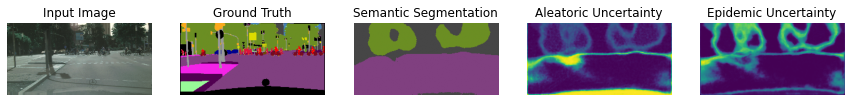

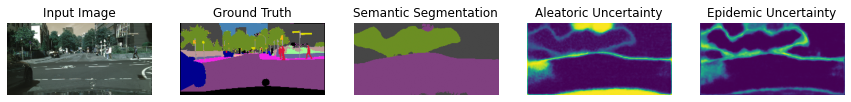

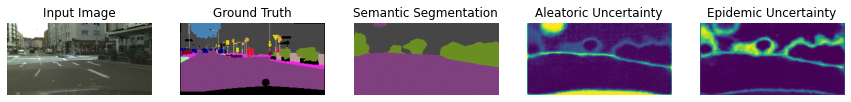

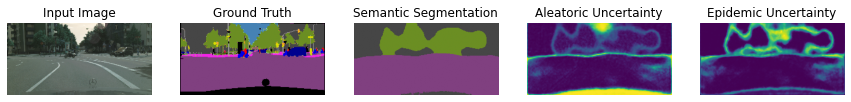

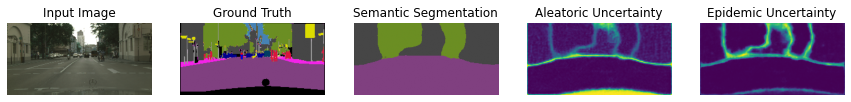

In [ ]:
draw()

3. Comment briefly on how the model’s performance could be improved. 
4. Please save your code and results for submission. 